## Stelios Giagkos f3352410
<h1>Part 2 Classification</h1>

##### Initial code given and the following Python libraries are used in this code:

In [3]:
import scipy.io as sio          # For handling MATLAB files and data I/O
import numpy as np              # For numerical operations on arrays and matrices
import scipy.optimize           # For optimization tasks
import matplotlib.pyplot as plt # For plotting data visualizations
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns

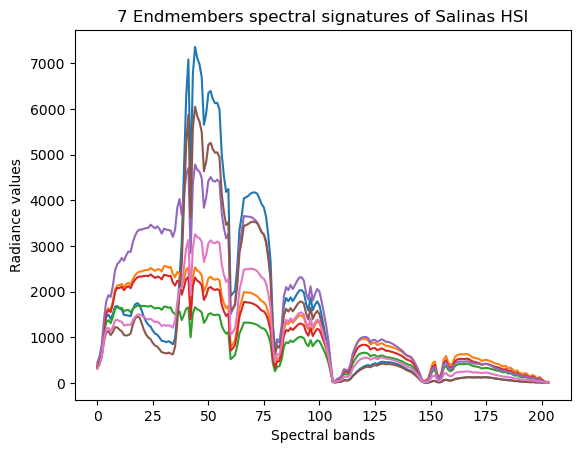

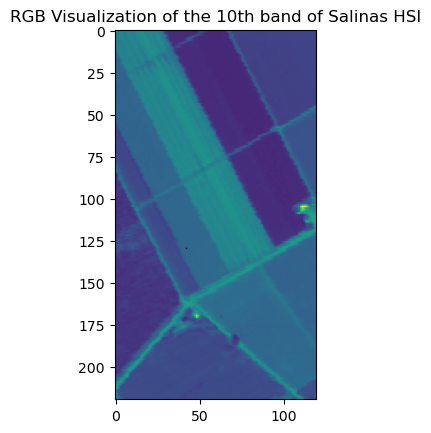

In [4]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
X = ends['salinas_endmembers']
cmap = plt.colormaps['gist_earth']  
fig = plt.figure()
plt.plot(X)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()



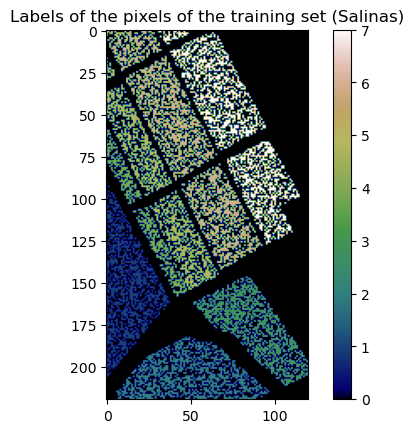

In [5]:
image_height,image_width=220,120
# Function to load and reshape dataset
def load_and_reshape_data(file_path, label_key, shape=(image_width,image_height)):
    data = sio.loadmat(file_path)
    return np.reshape(data[label_key], shape).T

# Define file path and label keys
file_path = "classification_labels_Salinas.mat"
label_keys = ['training_set', 'test_set', 'operational_set']

# Load and reshape data
Training_Set, Test_Set, Operational_Set = [load_and_reshape_data(file_path, key) for key in label_keys]

# Plot the training set
plt.imshow(Training_Set, cmap='gist_earth')  # Adjust cmap for better visualization
plt.title('Labels of the pixels of the training set (Salinas)')
plt.colorbar()  # Add a color bar to indicate label values
plt.show()


### Extract Non-zero Pixels from the Training, Test, and Operational Sets:

In [7]:
non_zero_indices = labels != 0

# Use these indices to select corresponding pixels from 'HSI' and 'labels'
X = HSI[non_zero_indices]
Y = labels[non_zero_indices]

# Check the shape of X after extraction
print(f" X shape: {X.shape}")

non_zero_indices_train = Training_Set != 0

# Use the indices to select corresponding pixels from 'HSI' and 'Training_Set'
X_train = HSI[non_zero_indices_train]
y_train = Training_Set[non_zero_indices_train]

# Check the shape of X_train after extraction
print(f" X train shape: {X_train.shape} Y train shape: {y_train.shape} ")

non_zero_indices_test = Test_Set != 0

# Use the indices to select corresponding pixels from 'HSI' and 'Test_Set'
X_test = HSI[non_zero_indices_test]
y_test = Test_Set[non_zero_indices_test]

# Check the shape of X_test after extraction
print(f" X test shape: {X_test.shape} Y test shape: {y_test.shape} ")

non_zero_indices_operational = Operational_Set != 0

# Use the indices to select corresponding pixels from 'HSI' and 'Operational_Set'
X_operational = HSI[non_zero_indices_operational]
y_operational = Operational_Set[non_zero_indices_operational]

# Check the shape of X_operational after extraction
print(f" X operational shape: {X_operational.shape} Y operational shape: {y_operational.shape} ")

 X shape: (16929, 204)
 X train shape: (8465, 204) Y train shape: (8465,) 
 X test shape: (4232, 204) Y test shape: (4232,) 
 X operational shape: (4232, 204) Y operational shape: (4232,) 


### Confusion Matrix Function

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]


def plot_confusion_matrix(cm, class_names, title):
    # Normalize the confusion matrix by the sum of each row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    
    # Create the heatmap
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens", cbar=True, 
                xticklabels=class_names, yticklabels=class_names,
                linewidths=0, square=True)  # Removes the outline by setting linewidths=0
    
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.show()



### Print plot Function

In [11]:
def plot_ground_truth_vs_prediction(ground_truth, predictions, title, class_names):
    # Extend class names to include "Background" at index 0
    extended_class_names = ["Background"] + class_names

    # Map predictions to spatial format
    predictions_mapped = np.zeros(ground_truth.shape)
    test_pixel_indices = np.where(ground_truth != 0)
    predictions_mapped[test_pixel_indices] = predictions + 1  # Shift class indices by 1 for background

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2)

    # Ground Truth
    img1 = axs[0].imshow(ground_truth, cmap='gist_earth', vmin=0, vmax=len(extended_class_names) - 1)
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')
    cbar1 = fig.colorbar(img1, ax=axs[0], ticks=np.arange(len(extended_class_names)))
    cbar1.ax.set_yticklabels(extended_class_names)

    # Predictions
    img2 = axs[1].imshow(predictions_mapped, cmap='gist_earth', vmin=0, vmax=len(extended_class_names) - 1)
    axs[1].set_title(title)
    axs[1].axis('off')
    cbar2 = fig.colorbar(img2, ax=axs[1], ticks=np.arange(len(extended_class_names)))
    cbar2.ax.set_yticklabels(extended_class_names)

    # Display the plot
    plt.tight_layout()
    plt.show()


## (A) Classifiers Training and Testing

### (A) (i) Naïve Bayes Classifier:
The Naïve Bayes classifier is based on Bayes' theorem, which calculates the probability of each class given the features, assuming independence between the features. It works by estimating the likelihood of the features for each class and selecting the class with the highest posterior probability. It is particularly useful when the features are conditionally independent given the class.

**1. Train the Naïve Bayes Classifier with 10-fold Cross-Validation**

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming X_train and y_train are your features and labels
nb_classifier = GaussianNB()

# 10-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X_train, y_train, cv=10)
mean_cv_score_nb = np.mean(cv_scores_nb)
std_cv_score_nb = np.std(cv_scores_nb)

# Output
print(f"Naive Bayes Mean CV Score: {mean_cv_score_nb:.3f}")
print(f"Naive Bayes CV Standard Deviation: {std_cv_score_nb:.3f}")


Naive Bayes Mean CV Score: 0.974
Naive Bayes CV Standard Deviation: 0.016


**2. Train the Naïve Bayes Classifier on the Full Training Set and Evaluate on the Test Set**

In [17]:
# Train the Naive Bayes classifier on the whole training set
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Success rate calculation
success_rate_nb = np.trace(conf_matrix_nb) / np.sum(conf_matrix_nb)

# Output
print(f"Naive Bayes Success Rate: {success_rate_nb * 100:.2f}%")


Naive Bayes Success Rate: 98.13%


**3. Naïve Bayes Classifier Confusion Matrix Visualization**

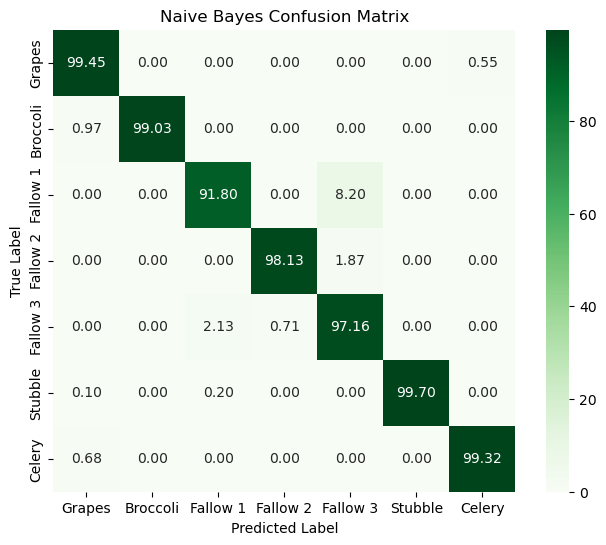

In [19]:
# Plot confusion matrix
plot_confusion_matrix(conf_matrix_nb, class_names,title="Naive Bayes Confusion Matrix")


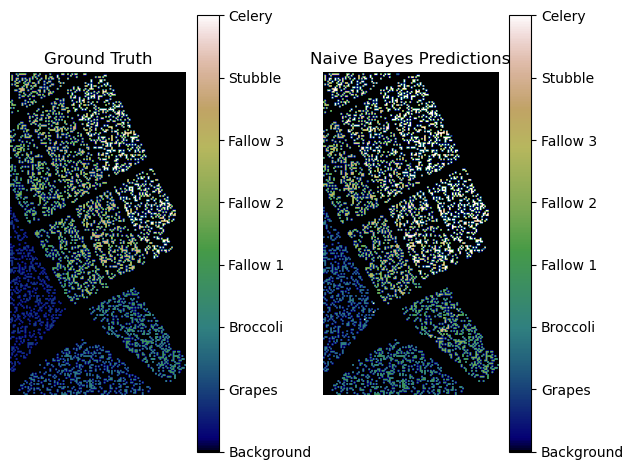

In [20]:
class_names = ["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]

plot_ground_truth_vs_prediction(Test_Set, y_pred_nb, "Naive Bayes Predictions", class_names)


### (A)(ii) Minimum Euclidean Distance Classifier
This classifier assigns a class to a sample based on the smallest Euclidean distance between the sample's feature vector and the centroids of each class in the feature space. It assumes that the feature distributions are spherical and isotropic, making it simple yet effective when the classes are well-separated.

**1. Train the Minimum Euclidean Distance Classifier with 10-fold Cross-Validation**

In [23]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Minimum Euclidean Distance Classifier (Custom Implementation)
class MinimumEuclideanDistanceClassifier:
    def __init__(self):
        self.class_means = {}
        self.scaler = StandardScaler()  # To scale the features

    # Fit the classifier by computing the centroid for each class
    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)  # Standardize the features
        unique_classes = np.unique(y)
        for cls in unique_classes:
            self.class_means[cls] = X_scaled[y == cls].mean(axis=0)

    # Predict labels for the test set
    def predict(self, X):
        X_scaled = self.scaler.transform(X)  # Standardize the test set features
        predictions = []
        for sample in X_scaled:
            distances = {cls: np.linalg.norm(sample - mean) for cls, mean in self.class_means.items()}
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)

In [24]:
# 10-fold Cross-validation
kf = KFold(n_splits=10)
cv_scores_euclid = []

# Create and initialize the classifier
classifier = MinimumEuclideanDistanceClassifier()

for train_index, val_index in kf.split(X_train):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the classifier
    classifier.fit(X_train_fold, y_train_fold)
    
    # Evaluate the classifier
    y_pred = classifier.predict(X_val_fold)
    accuracy = np.mean(y_pred == y_val_fold)
    cv_scores_euclid.append(accuracy)

# Compute the mean and standard deviation of the cross-validation scores
mean_cv_score_euclid = np.mean(cv_scores_euclid)
std_cv_score_euclid = np.std(cv_scores_euclid)

# Output the results
print(f"Minimum Euclidean Distance Mean CV Score: {mean_cv_score_euclid:.3f}")
print(f"Minimum Euclidean Distance CV Standard Deviation: {std_cv_score_euclid:.3f}")


Minimum Euclidean Distance Mean CV Score: 0.939
Minimum Euclidean Distance CV Standard Deviation: 0.109


**2. Train the Minimum Euclidean Distance Classifier on the Full Training Set and Evaluate on the Test Set**

In [26]:
# Train the classifier on the whole training set
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_euclidean = classifier.predict(X_test)

# Compute confusion matrix
conf_matrix_euclid = confusion_matrix(y_test, y_pred_euclidean)

# Success rate (accuracy)
success_rate_euclid = np.trace(conf_matrix_euclid) / np.sum(conf_matrix_euclid)

# Output the success rate
print(f"Minimum Euclidean Distance Success Rate: {success_rate_euclid * 100:.2f}%")

Minimum Euclidean Distance Success Rate: 95.82%


**3. Minimum Euclidean Distance Classifier Confusion Matrix Visualization**

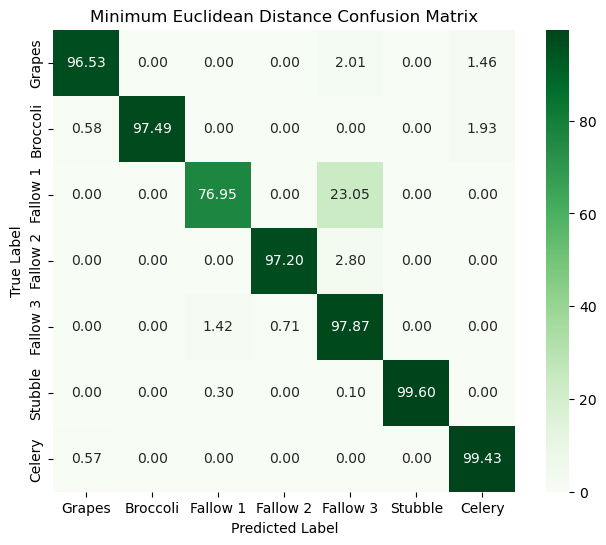

In [28]:
# Plot the confusion matrix for the test set
plot_confusion_matrix(conf_matrix_euclid,class_names, title="Minimum Euclidean Distance Confusion Matrix")

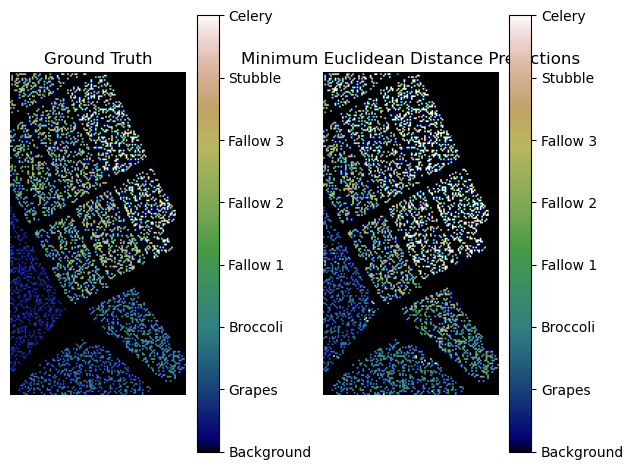

In [29]:
plot_ground_truth_vs_prediction(Test_Set, y_pred_euclidean, "Minimum Euclidean Distance Predictions", class_names)


### (A) (iii) K-Nearest Neighbor Classifier
KNN is a non-parametric method that classifies a sample based on the majority class among its k nearest neighbors in the feature space. The distance metric (typically Euclidean) is used to identify the closest samples in the training data. It is a flexible method that makes no assumptions about the data distribution but can be sensitive to the choice of k and the feature space scaling

**1. Train the K-Nearest Neighbor Classifier with 10-fold Cross-Validation**

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Initialize KNN classifier with a specific number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Perform 10-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X_train, y_train, cv=10)
mean_cv_score_knn = np.mean(cv_scores_knn)
std_cv_score_knn = np.std(cv_scores_knn)

# Output
print(f"KNN Mean CV Score: {mean_cv_score_knn:.4f}")
print(f"KNN CV Standard Deviation: {std_cv_score_knn:.4f}")


KNN Mean CV Score: 0.9911
KNN CV Standard Deviation: 0.0130


**2. Train the K-Nearest Neighbor Classifier  on the Full Training Set and Evaluate on the Test Set**

In [34]:
# Train KNN classifier on the whole training set
knn_classifier.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_classifier.predict(X_test)

# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Success rate
success_rate_knn = np.trace(conf_matrix_knn) / np.sum(conf_matrix_knn)

# Output
print(f"KNN Success Rate: {success_rate_knn * 100:.2f}%")

KNN Success Rate: 99.72%


**3. K-Nearest Neighbor Classifier Confusion Matrix Visualization**

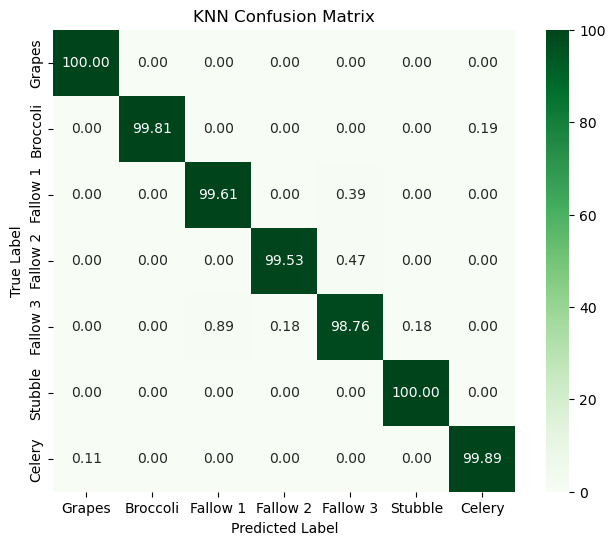

In [36]:
# Plot confusion matrix
plot_confusion_matrix(conf_matrix_knn, class_names,title="KNN Confusion Matrix")

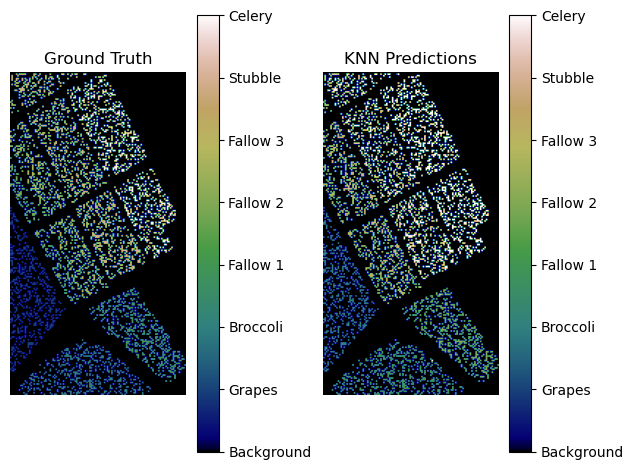

In [37]:
plot_ground_truth_vs_prediction(Test_Set, y_pred_knn, "KNN Predictions", class_names)


### (A) (iv) Bayesian Classifier
QDA is a probabilistic classifier that assumes each class is normally distributed with its own mean and covariance matrix. It uses Bayes' theorem for classification but allows for quadratic decision boundaries (unlike Linear Discriminant Analysis). QDA is suitable for problems where classes have different covariance structures, allowing it to capture more complex relationships in the data.

**1. Train the Bayesian Classifier with 10-fold Cross-Validation**

In [40]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Quadratic Discriminant Analysis (QDA) classifier
bayesian_classifier = QuadraticDiscriminantAnalysis()

# Perform 10-fold cross-validation
cv_scores_bayesian = cross_val_score(bayesian_classifier, X_train, y_train, cv=10)
mean_cv_score_bayesian = np.mean(cv_scores_bayesian)
std_cv_score_bayesian = np.std(cv_scores_bayesian)

# Output the results
print(f"QDA Mean CV Score: {mean_cv_score_bayesian:.3f}")
print(f"QDA CV Standard Deviation: {std_cv_score_bayesian:.3f}")


QDA Mean CV Score: 0.966
QDA CV Standard Deviation: 0.006


**2. Train the Bayesian Classifier on the Full Training Set and Evaluate on the Test Set**

In [42]:
# Train Bayesian classifier on the whole training set
bayesian_classifier.fit(X_train, y_train)

# Predict on test set
y_pred_bayesian = bayesian_classifier.predict(X_test)

# Compute confusion matrix
conf_matrix_bayesian = confusion_matrix(y_test, y_pred_bayesian)

# Success rate
success_rate_bayesian = np.trace(conf_matrix_bayesian) / np.sum(conf_matrix_bayesian)

# Output
print(f"Bayesian Success Rate: {success_rate_bayesian * 100:.2f}%")


Bayesian Success Rate: 97.78%


**3. Bayesian Classifier Confusion Matrix Visualization**

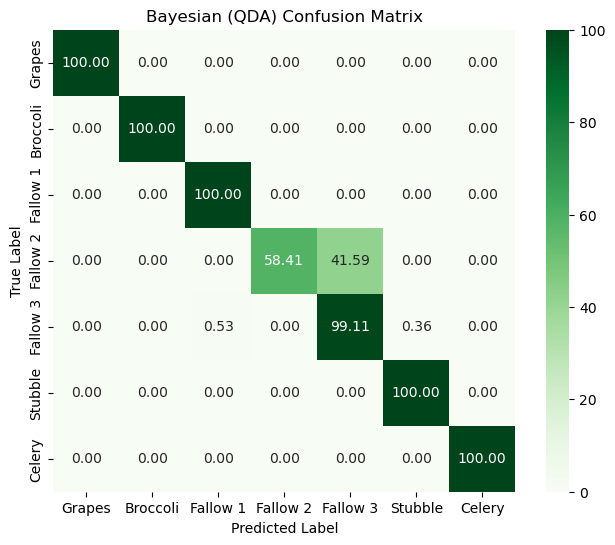

In [44]:
# Plot confusion matrix
plot_confusion_matrix(conf_matrix_bayesian,class_names, title="Bayesian (QDA) Confusion Matrix")


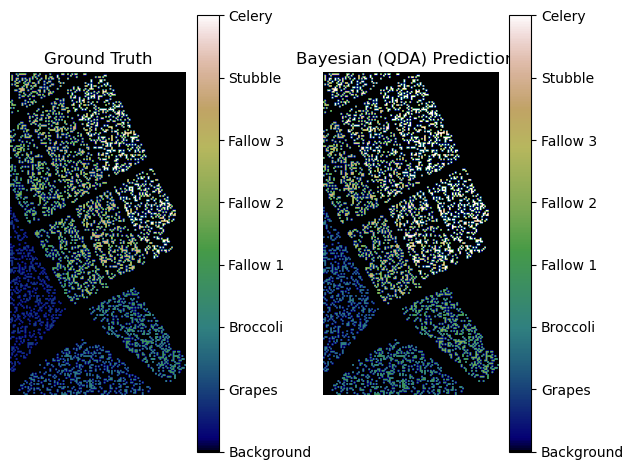

In [45]:
plot_ground_truth_vs_prediction(Test_Set, y_pred_bayesian, "Bayesian (QDA) Predictions", class_names)


## (B) Compare the results of the classifiers and their confusion matrices

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of confusion matrices for each classifier
cmlist = [conf_matrix_nb, conf_matrix_euclid, conf_matrix_knn, conf_matrix_bayesian]

# Class names (as per previous context)
class_names = ["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Increase figure size for better spacing
titles = ['Naive Bayes', 'Euclidean', 'KNN', 'Bayesian']

for i, ax in enumerate(axes.flat):
    sns.heatmap(cmlist[i], annot=True, fmt="d", cmap="Greens", ax=ax, cbar=True,
                xticklabels=class_names, yticklabels=class_names, square=True)  # Ensure square aspect
    ax.set_title(titles[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Adjust layout to prevent overlap and make it neater
plt.subplots_adjust(wspace=0.4, hspace=0.3)  # Increase the space between subplots

plt.close(fig)


In [86]:
import pandas as pd

# Assuming these variables are already computed
# - mean_cv_score_nb, std_cv_score_nb, success_rate_nb
# - mean_cv_score_euclid, std_cv_score_euclid, success_rate_euclid
# - mean_cv_score_knn, std_cv_score_knn, success_rate_knn
# - mean_cv_score_bayesian, std_cv_score_bayesian, success_rate_bayesian

# Create a dictionary with the results including cross-validation errors
results = {
    'Method': ['Naive Bayes', 'Euclidean', 'KNN', 'Bayesian (QDA)'],
    'Mean CV Score': [mean_cv_score_nb, mean_cv_score_euclid, mean_cv_score_knn, mean_cv_score_bayesian],
    'CV Standard Deviation': [std_cv_score_nb, std_cv_score_euclid, std_cv_score_knn, std_cv_score_bayesian],
    'CV Error Rate (%)': [(1 - mean_cv_score_nb) * 100, 
                          (1 - mean_cv_score_euclid) * 100, 
                          (1 - mean_cv_score_knn) * 100, 
                          (1 - mean_cv_score_bayesian) * 100],
    'Success Rate (%)': [success_rate_nb * 100, success_rate_euclid * 100, success_rate_knn * 100, success_rate_bayesian * 100],
    
}

# Create a DataFrame
df_results = pd.DataFrame(results)

# Print the DataFrame
df_results


,Method,Mean CV Score,CV Standard Deviation,CV Error Rate (%),Success Rate (%)
0,Naive Bayes,0.973776,0.016023,2.622397,98.133270
1,Euclidean,0.939248,0.108909,6.075176,95.817580
2,KNN,0.991138,0.012962,0.886218,99.716446
3,Bayesian (QDA),0.965739,0.005851,3.426124,97.778828


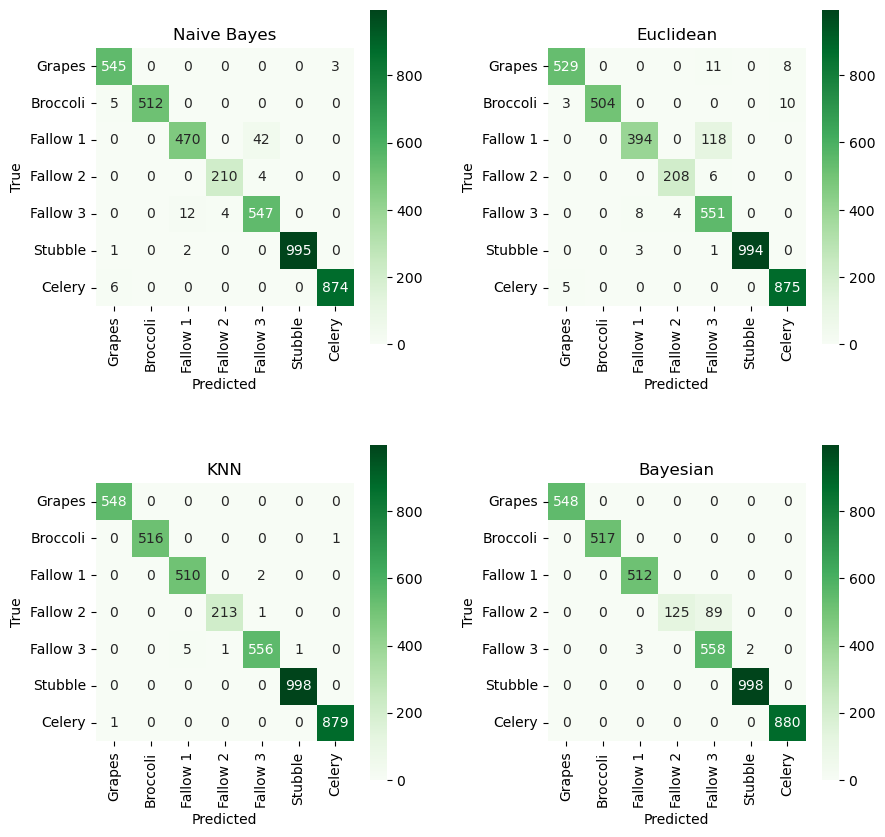

In [88]:
fig

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_classifiers_in_row(ground_truth, classifiers, class_names):
    """
    Plots the ground truth and all classifier predictions in a single row with 5 columns.

    Parameters:
    - ground_truth: 2D array of the ground truth labels.
    - classifiers: Dictionary where keys are classifier names and values are 1D prediction arrays.
    - class_names: List of class names, where index 0 corresponds to the background class.
    """
    # Extend class names to include "Background" at index 0
    extended_class_names = ["Background"] + class_names

    # Prepare the figure
    fig, axs = plt.subplots(1, 5, figsize=(25, 6))
    
    # Plot Ground Truth
    img1 = axs[0].imshow(ground_truth, cmap='gist_earth', vmin=0, vmax=len(extended_class_names) - 1)
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')
    cbar1 = fig.colorbar(img1, ax=axs[0], ticks=np.arange(len(extended_class_names)))
    cbar1.ax.set_yticklabels(extended_class_names)

    # Plot each classifier
    for i, (classifier_name, predictions) in enumerate(classifiers.items(), start=1):
        # Map predictions to spatial format
        predictions_mapped = np.zeros(ground_truth.shape)
        test_pixel_indices = np.where(ground_truth != 0)
        predictions_mapped[test_pixel_indices] = predictions + 1  # Shift predictions for background

        # Plot predictions
        img2 = axs[i].imshow(predictions_mapped, cmap='gist_earth', vmin=0, vmax=len(extended_class_names) - 1)
        axs[i].set_title(classifier_name)
        axs[i].axis('off')
        cbar2 = fig.colorbar(img2, ax=axs[i], ticks=np.arange(len(extended_class_names)))
        cbar2.ax.set_yticklabels(extended_class_names)

    plt.tight_layout()
    plt.show()


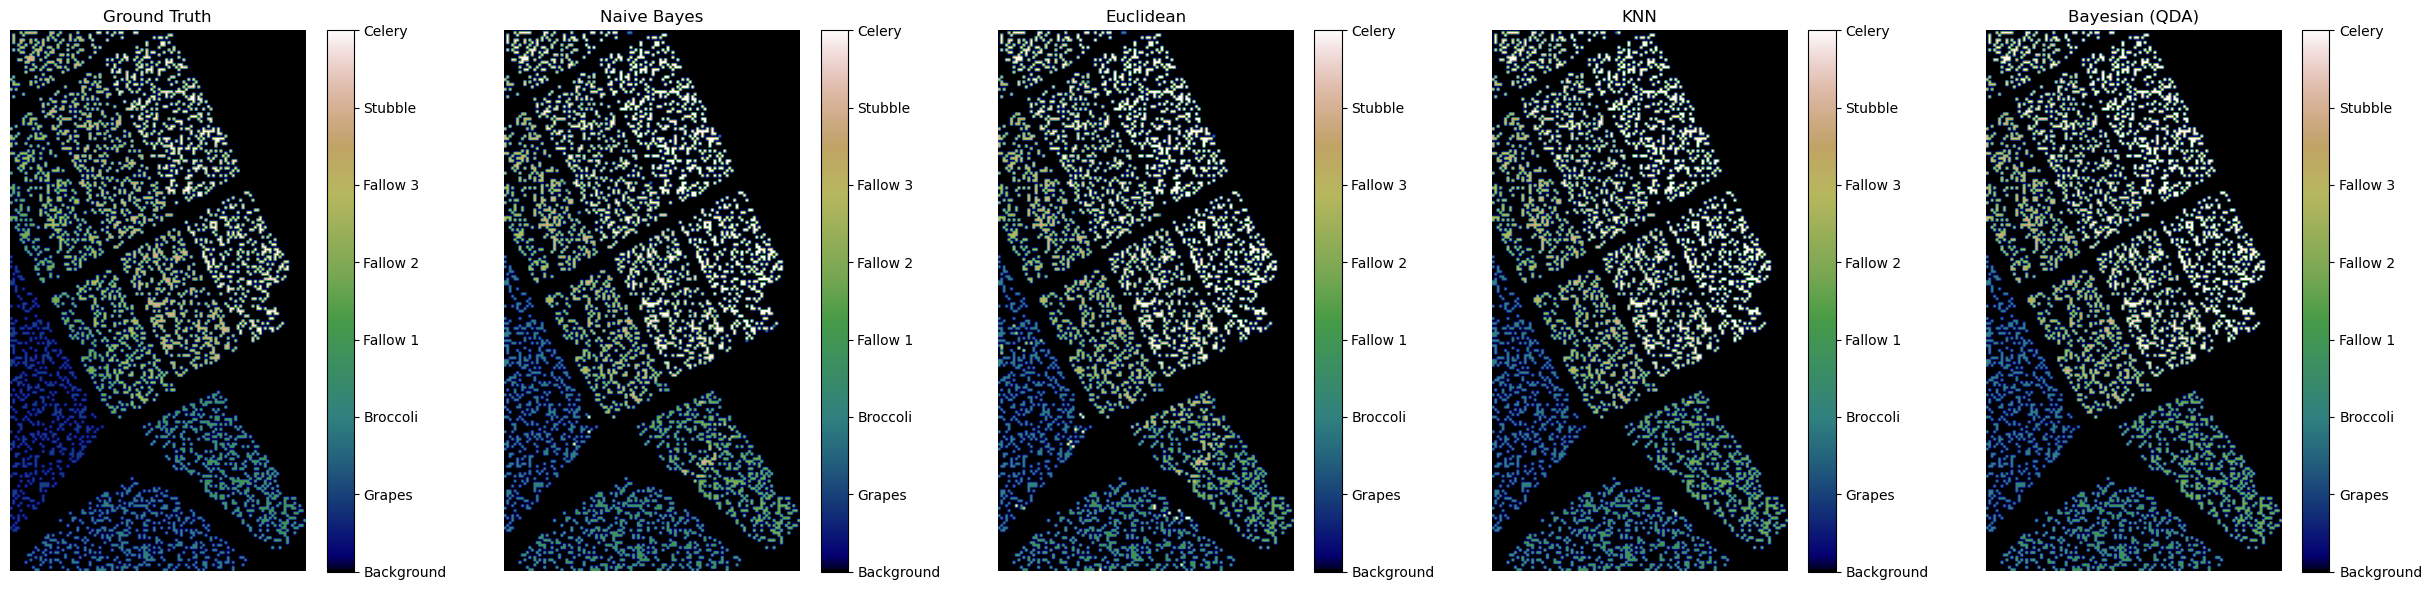

In [51]:
class_names = ["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]

classifiers = {
    'Naive Bayes': y_pred_nb,
    'Euclidean': y_pred_euclidean,
    'KNN': y_pred_knn,
    'Bayesian (QDA)': y_pred_bayesian
}

plot_all_classifiers_in_row(Test_Set, classifiers, class_names)


## Conclusions

**1. Naive Bayes:**  
This classifier performs well, with most predictions correctly classified along the diagonal. However, some notable misclassifications include:
- *Fallow 1* (Class 3) has 42 instances misclassified as *Fallow 3* (Class 5).
- *Fallow 3* (Class 5) has 12 instances misclassified as *Fallow 1* (Class 3).

With an overall success rate of approximately 98.13%, Naive Bayes effectively classifies most instances, though there is some confusion between *Fallow 1*, *Fallow 2*, and *Fallow 3*.

**2. Euclidean Distance Classifier:**  
This classifier shows the weakest performance among the four, with a significantly lower success rate of around 93.92%. Higher non-diagonal values indicate substantial misclassifications:
- *Fallow 1* (Class 3) is frequently misclassified as *Fallow 3* (Class 5), with 118 instances.
 
These misclassifications suggest that the Euclidean classifier struggles with differentiating between certain classes, especially *Fallow 1*, *Fallow 3*.

**3. K-Nearest Neighbors (KNN):**  
KNN achieves the highest success rate of about 99.72%, with very few non-diagonal entries, indicating minimal misclassifications. The primary misclassifications observed are:
- *Fallow 2* (Class 4) has 1 instance misclassified as *Fallow 3* (Class 5).

- A similar range of misclassifications exists for other classes too.  

Overall, KNN shows excellent separation between classes, with almost all instances correctly classified, suggesting that it is the most reliable classifier for this dataset.

**4. Bayesian (QDA):**  
This classifier also performs well, with a success rate of 97.78%, though slightly lower than Naive Bayes and KNN. Notable misclassifications include:  
- 89 instances of *Fallow 2* (Class 4) misclassified as *Fallow 3* (Class 5).  

These non-diagonal entries indicate that QDA struggles with separating *Fallow 2* and *Fallow 3*. However, it generally performs well, as indicated by its high accuracy.

**Overall Comparison and Summary:**

- KNN outperforms the other classifiers, achieving the highest accuracy and minimal misclassification. This makes it the most robust choice for this dataset.

- Naive Bayes and Bayesian (QDA) also perform well, though both show some misclassification between similar classes like *Broccoli*, *Fallow 1*, and *Fallow 3*. Naive Bayes is slightly better than QDA, as indicated by its higher success rate.

- Euclidean shows the weakest performance, with significant confusion among Fallow 1 and 3 classes. This classifier is less effective for this dataset due to its tendency to confuse certain classes with one another.

In conclusion, KNN is the top-performing classifier, followed by Naive Bayes and Bayesian (QDA), while Euclidean is the least reliable. The confusion matrices reveal that KNN and Naive Bayes can accurately distinguish between classes, while Euclidean struggles significantly, likely due to overlapping feature spaces in the data.